<a href="https://colab.research.google.com/github/mirpouya/TensorFlow-Tutorial/blob/main/Human_Emotion_Detection(only%20classify%20sad%20correctly).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers  import L2, L1

import cv2

In [2]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [3]:
train_directory = "/content/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test"

In [4]:
! pip install -q kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pouyammsadeghi","key":"773ac957be00991204924caaf65a4f47"}'}

In [6]:
 ! mkdir ~/.kaggle

In [8]:
! cp kaggle.json ~/.kaggle/

In [9]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 97% 299M/309M [00:02<00:00, 105MB/s]
100% 309M/309M [00:02<00:00, 127MB/s]


In [ ]:
! mkdir human-emotions-datasethes
! unzip human-emotions-datasethes.zip -d human-emotions-datasethes

In [69]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='int',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [70]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='int',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


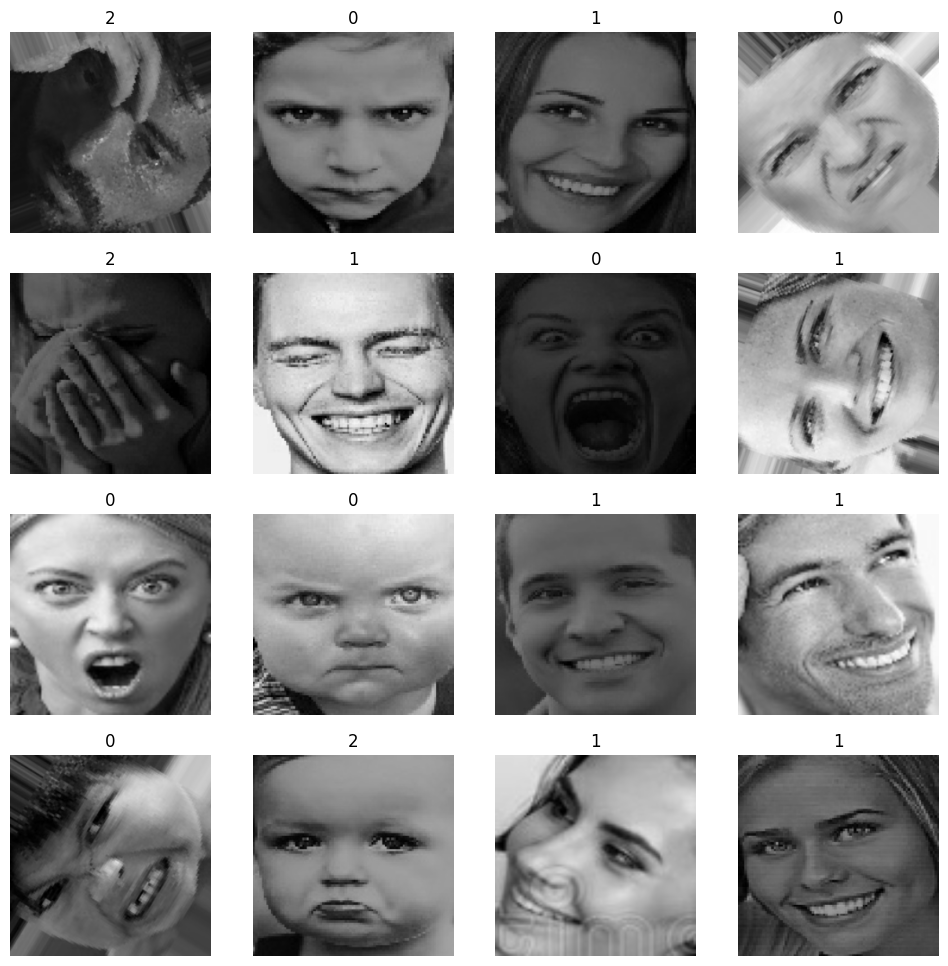

In [71]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title((labels[i]).numpy())
    plt.axis("off")

In [72]:
training_dataset = (
    train_dataset.prefetch(tf.data.AUTOTUNE)
)

In [73]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [74]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255)
])

In [75]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [76]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [77]:
lenet_model_1 = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 254, 254, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 6)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 16)     

In [78]:
#loss_function = CategoricalCrossentropy()
loss_function = SparseCategoricalCrossentropy()

In [79]:
metrics = [SparseCategoricalAccuracy()]

In [80]:
lenet_model_1.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [81]:
history = lenet_model_1.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  #epochs = 5,
  verbose = 1,
  #class_weight = class_weights,
  #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
)

Epoch 1/20
213/213 [==============================] - 23s 91ms/step - loss: 0.9455 - sparse_categorical_accuracy: 0.5688 - val_loss: 1.0821 - val_sparse_categorical_accuracy: 0.4004
Epoch 2/20
213/213 [==============================] - 15s 69ms/step - loss: 0.6343 - sparse_categorical_accuracy: 0.7325 - val_loss: 1.2935 - val_sparse_categorical_accuracy: 0.4982
Epoch 3/20
213/213 [==============================] - 15s 69ms/step - loss: 0.3711 - sparse_categorical_accuracy: 0.8654 - val_loss: 1.1441 - val_sparse_categorical_accuracy: 0.5544
Epoch 4/20
213/213 [==============================] - 15s 69ms/step - loss: 0.2261 - sparse_categorical_accuracy: 0.9241 - val_loss: 0.8913 - val_sparse_categorical_accuracy: 0.7160
Epoch 5/20
213/213 [==============================] - 15s 68ms/step - loss: 0.1881 - sparse_categorical_accuracy: 0.9363 - val_loss: 0.9157 - val_sparse_categorical_accuracy: 0.7243
Epoch 6/20
213/213 [==============================] - 16s 74ms/step - loss: 0.1274 - spars

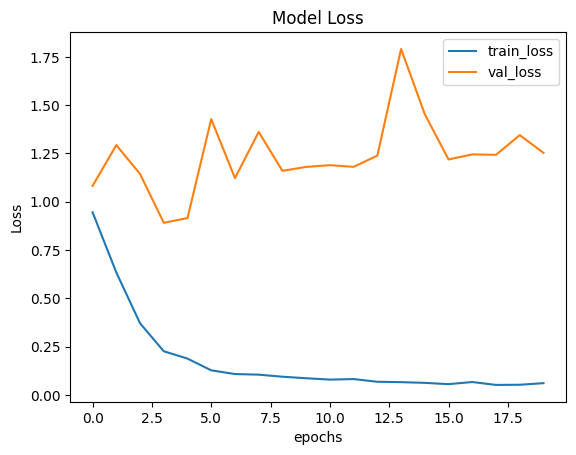

In [82]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.legend(["train_loss", "val_loss"])
plt.show()

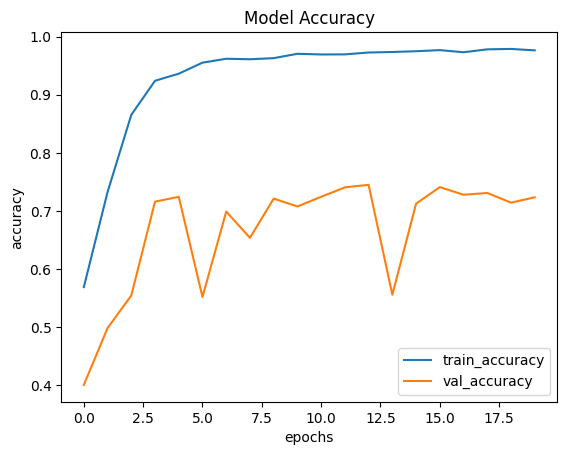

In [83]:
plt.plot(history.history["sparse_categorical_accuracy"])
plt.plot(history.history["val_sparse_categorical_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

<b> <h2> Evaluation </h2> <b>

In [84]:
lenet_model_1.evaluate(validation_dataset)

72/72 [==============================] - 3s 42ms/step - loss: 1.2532 - sparse_categorical_accuracy: 0.7234


[1.2532408237457275, 0.7234416007995605]

In [85]:
# evaluating on train data

lenet_model_1.evaluate(training_dataset)

213/213 [==============================] - 8s 34ms/step - loss: 0.0952 - sparse_categorical_accuracy: 0.9713


[0.09518894553184509, 0.971319317817688]

<b> The model is overfitting </b>

<b> <h2> Testing </h2> </b>

In [86]:
test_image = cv2.imread("/content/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/train/sad/10416.jpg_brightness_1.jpg")

In [87]:
im = tf.constant(test_image, dtype=tf.float32)

In [88]:
print(im.shape)

(224, 224, 3)


In [89]:
im = tf.expand_dims(im, axis=0)
print(im.shape)

(1, 224, 224, 3)


In [90]:
lenet_model_1(im)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.2504576e-04, 4.2428439e-03, 9.9563211e-01]], dtype=float32)>

In [105]:
print(CONFIGURATION["CLASS_NAMES"][tf.argmax(lenet_model_1(im), axis=-1).numpy()[0]])

sad


In [112]:
for images, labels in validation_dataset.take(1):
  print(tf.argmax(lenet_model_1(images), axis=-1))
  print(CONFIGURATION["CLASS_NAMES"][tf.argmax(lenet_model_1(images), axis=-1).numpy()[0]])

tf.Tensor([1 1 2 1 2 1 2 1 0 2 1 2 1 1 1 1 2 1 0 2 1 2 1 2 1 2 0 1 0 0 1 1], shape=(32,), dtype=int64)
happy


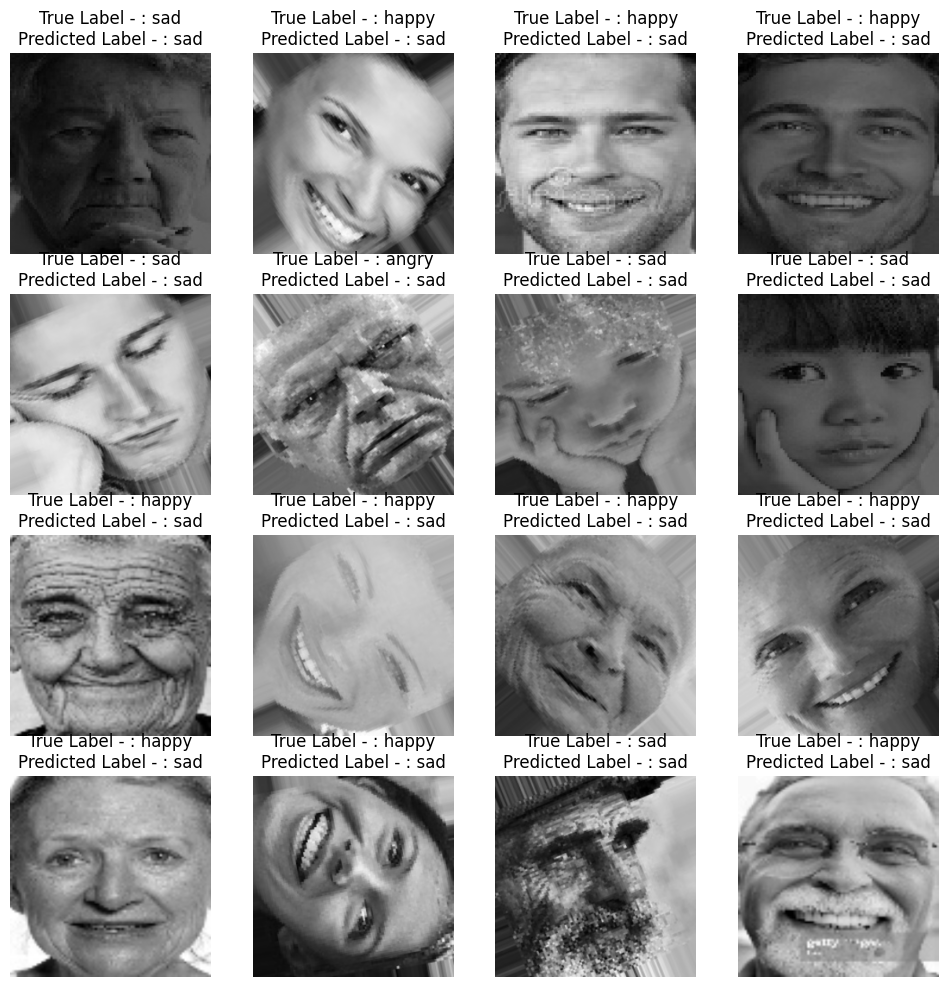

In [115]:
plt.figure(figsize = (12,12))

for images, labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title("True Label - : " + CONFIGURATION["CLASS_NAMES"][(labels[i]).numpy()]
              + "\n" + "Predicted Label - : "
              +CONFIGURATION["CLASS_NAMES"][tf.argmax(lenet_model_1(images), axis=-1).numpy()[0]])
    plt.axis("off")